In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

In [1]:


# 1. Load your CSV file
df = pd.read_csv('stellar_database.csv')



In [2]:
df

,loc_rowid,pl_name,hostname,sy_snum,sy_pnum,st_teff,st_rad,st_mass,st_met,st_lum,st_age,st_vsin
0,1,11 Com b,11 Com,2,1,4874.0,13.76,2.09,-0.260,1.97823,NaN,NaN
1,2,11 Com b,11 Com,2,1,NaN,NaN,2.60,NaN,NaN,NaN,NaN
2,3,11 Com b,11 Com,2,1,4742.0,19.00,2.70,-0.350,2.24300,NaN,1.20
3,4,11 UMi b,11 UMi,1,1,NaN,NaN,1.70,NaN,NaN,NaN,NaN
4,5,11 UMi b,11 UMi,1,1,4340.0,24.08,1.80,0.040,NaN,1.56,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...
38947,38948,ups And d,ups And,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38948,38949,ups Leo b,ups Leo,1,1,4836.0,11.22,1.48,-0.200,1.80003,NaN,1.78
38949,38950,xi Aql b,xi Aql,1,1,NaN,NaN,1.40,NaN,NaN,NaN,NaN
38950,38951,xi Aql b,xi Aql,1,1,4780.0,12.00,2.20,-0.205,1.83885,NaN,NaN


In [3]:

# 2. Group by planet name and apply the rules in one step
# - 'mean': Calculates the average for these columns, ignoring empty cells.
# - 'first': Takes the first non-empty value for all other columns.
merged_df = df.groupby('pl_name').agg({
    'st_teff': 'mean',
    'st_mass': 'mean',
    'st_rad': 'mean',
    'hostname': 'first',
    'sy_snum': 'first',
    'sy_pnum': 'first',
    'st_met': 'first',
    'st_lum': 'first',
    'st_age': 'first',
    'st_vsin': 'first'
}).reset_index()

# 3. Print the result
print(merged_df)


         pl_name      st_teff   st_mass     st_rad  hostname  sy_snum  \
0       11 Com b  4808.000000  2.463333  16.380000    11 Com        2   
1       11 UMi b  4276.500000  2.093333  26.935000    11 UMi        1   
2       14 And b  4850.500000  1.726667  11.275000    14 And        1   
3       14 Her b  5296.985000  0.927029   0.976056    14 Her        1   
4     16 Cyg B b  5728.594000  1.016599   1.139245  16 Cyg B        3   
...          ...          ...       ...        ...       ...      ...   
6017   ups And b  6137.820000  1.250839   1.614742   ups And        2   
6018   ups And c  6117.093333  1.263549   1.614742   ups And        2   
6019   ups And d  6117.093333  1.263549   1.614742   ups And        2   
6020   ups Leo b  4836.000000  1.480000  11.220000   ups Leo        1   
6021    xi Aql b  4810.500000  1.780000  11.430000    xi Aql        1   

      sy_pnum  st_met   st_lum  st_age  st_vsin  
0           1 -0.2600  1.97823     NaN     1.20  
1           1  0.0400  

In [4]:

# 3. NEW (Simpler): Fill all remaining NaNs in numeric columns with their respective averages
merged_df.fillna(merged_df.mean(numeric_only=True), inplace=True)
print(merged_df)

         pl_name      st_teff   st_mass     st_rad  hostname  sy_snum  \
0       11 Com b  4808.000000  2.463333  16.380000    11 Com        2   
1       11 UMi b  4276.500000  2.093333  26.935000    11 UMi        1   
2       14 And b  4850.500000  1.726667  11.275000    14 And        1   
3       14 Her b  5296.985000  0.927029   0.976056    14 Her        1   
4     16 Cyg B b  5728.594000  1.016599   1.139245  16 Cyg B        3   
...          ...          ...       ...        ...       ...      ...   
6017   ups And b  6137.820000  1.250839   1.614742   ups And        2   
6018   ups And c  6117.093333  1.263549   1.614742   ups And        2   
6019   ups And d  6117.093333  1.263549   1.614742   ups And        2   
6020   ups Leo b  4836.000000  1.480000  11.220000   ups Leo        1   
6021    xi Aql b  4810.500000  1.780000  11.430000    xi Aql        1   

      sy_pnum  st_met    st_lum    st_age   st_vsin  
0           1 -0.2600  1.978230  4.626928  1.200000  
1           1  

In [5]:

# 2. Keep only single-star systems.
# First, safely convert the 'sy_snum' column to numbers.
# 'errors='coerce'' will turn any text that isn't a number into an empty value (NaN).
merged_df['sy_snum'] = pd.to_numeric(merged_df['sy_snum'], errors='coerce')

# Now, keep only the rows where sy_snum is exactly 1.
# We also drop any rows where the conversion failed.
merged_df = merged_df.dropna(subset=['sy_snum'])
merged_df = merged_df[merged_df['sy_snum'] == 1]
print(f"Filtered down to {merged_df.shape[0]} rows for single-star systems.")

# 3. Group by 'hostname' and calculate the mean for all numerical columns.
# This collapses all rows for a single star into one summary row.
merged_df = merged_df.groupby('hostname').mean(numeric_only=True)

# 4. Make 'hostname' a regular column again instead of the index.
merged_df = merged_df.reset_index()
print(merged_df)

Filtered down to 5470 rows for single-star systems.
                   hostname      st_teff   st_mass     st_rad  sy_snum  \
0                    11 UMi  4276.500000  2.093333  26.935000      1.0   
1                    14 And  4850.500000  1.726667  11.275000      1.0   
2                    14 Her  5305.962500  0.933316   0.985938      1.0   
3                    17 Sco  4157.000000  1.220000  25.920000      1.0   
4     1RXS J160929.1-210524  4043.250000  0.793250   1.332580      1.0   
...                     ...          ...       ...        ...      ...   
4078                rho CrB  5779.982708  0.938573   1.343511      1.0   
4079                tau Cet  5415.146317  0.783000   1.507859      1.0   
4080                tau Gem  4435.000000  2.300000  27.757600      1.0   
4081                ups Leo  4836.000000  1.480000  11.220000      1.0   
4082                 xi Aql  4810.500000  1.780000  11.430000      1.0   

      sy_pnum    st_met    st_lum     st_age   st_vsin  
0 

In [7]:
merged_df.to_csv('stellar_database_cleaned.csv')

# Training

In [16]:

# This is the key change to remove the 'Unnamed: 0' column
df = pd.read_csv('stellar_database_cleaned.csv', index_col=0)

# Prepare the data for the model by dropping non-numeric columns and missing values
df_numeric = df.drop('hostname', axis=1).dropna()

# Split the data into 80% training and 20% testing sets
# We only need the features (X) for this unsupervised task
X_train, X_test = train_test_split(df_numeric, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Initialize and train the Isolation Forest model on the training data
iso_forest = IsolationForest(contamination='auto', random_state=42)
iso_forest.fit(X_train)

# Get the anomaly scores for the test set.
# score_samples returns the opposite of the anomaly score, so we negate it.
# Higher scores will now mean more anomalous.
anomaly_scores = -iso_forest.score_samples(X_test)

# Reshape scores for the scaler
anomaly_scores = anomaly_scores.reshape(-1, 1)

# Use MinMaxScaler to scale the scores to a 0-1 range
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(anomaly_scores)

# Invert the score: 1 is now "good" (least anomalous), 0 is "bad" (most anomalous)
inverted_scores = 1 - normalized_scores
# -----------------------------------------

# Add the new inverted score to our test data
X_test['normality_score'] = inverted_scores

# Sort the test set by anomaly score in descending order to see the most anomalous points first
X_test_sorted = X_test.sort_values(by='normality_score', ascending=False)

# Display the top 10 most anomalous data points in the test set
print("\nTop 10 most anomalous data points in the test set:")
print(X_test_sorted)


Training set size: 3266
Testing set size: 817

Top 10 most anomalous data points in the test set:
          st_teff   st_mass     st_rad  sy_snum  sy_pnum    st_met    st_lum  \
1961  5507.777778  0.949250   0.911368      1.0      1.0  0.020000 -0.135360   
12    5415.146317  0.937411   1.507859      1.0      1.0 -0.011614 -0.134122   
124   5415.146317  0.937411   1.507859      1.0      1.0 -0.011614 -0.134122   
573   5415.146317  1.050000   1.507859      1.0      1.0 -0.011614 -0.134122   
511   5415.146317  1.000000   1.507859      1.0      1.0 -0.011614 -0.134122   
...           ...       ...        ...      ...      ...       ...       ...   
26    9770.000000  2.400000   1.507859      1.0      1.0 -0.011614  1.770850   
408   4179.700000  2.240000  40.197150      1.0      1.0 -0.370000 -0.134122   
3976  8000.000000  2.030000   2.360000      1.0      1.0  0.290000 -0.134122   
729   3802.000000  2.490000  86.400000      1.0      1.0 -0.030000  3.223980   
1474  9241.000000  2.2

In [17]:

# Save the results to a new CSV file
X_test_sorted.to_csv('test_data_with_normality_scores.csv', index=False)

print("\nTest data with 'normality_score' saved to 'test_data_with_normality_scores.csv'")



Test data with 'normality_score' saved to 'test_data_with_normality_scores.csv'


In [22]:
# --- 1. ONE-LINER TO COUNT VALUES ---
# This counts the number of data points with a normality score between 0.6 and 1.0
high_score_count = X_test['normality_score'].between(0.6, 1.0).sum()
# ------------------------------------
high_score_percent = (high_score_count / len(X_test)) * 100

print(f"Number of data points with a normality score from 0.6 to 1.0: {high_score_count}")
print(f"Which is {high_score_percent:.2f}% of the test set.")



Number of data points with a normality score from 0.6 to 1.0: 734
Which is 89.84% of the test set.


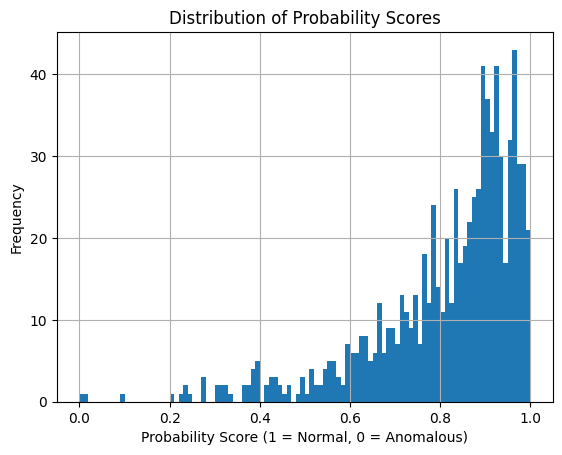

In [25]:
# This plots a histogram of the normality scores
X_test['normality_score'].hist(bins=100)
# ------------------------------------------

plt.title('Distribution of Probability Scores')
plt.xlabel('Probability Score (1 = Normal, 0 = Anomalous)')
plt.ylabel('Frequency')
plt.savefig('normality_score_distribution.png')

In [27]:
# --- SAVE THE MODEL TO A FILE ---
# Define a filename for your model
model_filename = 'isolation_forest_model.pkl'

# Open the file in write-binary mode and save the model
with open(model_filename, 'wb') as file:
    pickle.dump(iso_forest, file)

print(f"Model has been trained and saved to '{model_filename}'")
# --------------------------------

Model has been trained and saved to 'isolation_forest_model.pkl'


In [28]:
# Save the fitted scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)